# Unbinned Profiled Unfolding

In [1]:
%load_ext tensorboard
import os, sys
import datetime
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from torch import nn, optim

from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, ProgressBar
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, roc_auc_score
dvc = "cuda" if torch.cuda.is_available() else "cpu"
device = "gpu" if torch.cuda.is_available() else "cpu"
# dvc=device="cpu"
print(f"Using {device} device")

/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using gpu device


In [2]:
# Data sets for training W0 and training W1

class w0_dataset(Dataset):
    def __init__(self, T, R):
        super(w0_dataset, self).__init__()
        
        self.T = T
        self.R = R
        
    def __len__(self):
        return len(self.T)

    def __getitem__(self, idx):
        return self.T[idx], self.R[idx]
    
class w1_dataset(Dataset):
    def __init__(self, T0, R0, theta0, T1, R1, theta1):
        super(w1_dataset, self).__init__()
        
        self.T = np.concatenate([T0, T1])
        self.R = np.concatenate([R0, R1])
        self.theta = np.concatenate([theta0, theta1])
        self.label = np.concatenate([np.zeros((len(T0), 1)), np.ones((len(T1), 1))])
                
    def __len__(self):
        return len(self.T)

    def __getitem__(self, idx):
        return self.T[idx], self.R[idx], self.theta[idx], self.label[idx]

In [3]:
# Loss function (NLL)

class NLLLoss(nn.Module):

    def __init__(self, obs_data, bins, normalize=False, device="cpu"):
        super(NLLLoss, self).__init__()
        self.normalize = normalize
        self.dvc = device
        if type(obs_data) == torch.Tensor:
            self.obs_data = obs_data.float().to(self.dvc)
        elif type(obs_data) == np.ndarray:
            self.obs_data = torch.from_numpy(obs_data).float().to(self.dvc)
        elif type(obs_data) == list:
            self.obs_data = torch.tensor(obs_data).float().to(self.dvc)
        if type(bins) == torch.Tensor:
            self.bins = bins.float().to(self.dvc)
        elif type(bins) == np.ndarray:
            self.bins = torch.from_numpy(bins).float().to(self.dvc)
        elif type(bins) == list:
            self.bins = torch.tensor(bins).float().to(self.dvc)
        self.h_obs_data = torch.tensor([(torch.bucketize(self.obs_data, self.bins)==i).sum() for i in range(1, len(self.bins))]).to(self.dvc)
        self.y_obs_data = len(self.obs_data)
        
    def forward(self, R, weights, theta):
        h_R = None
        for i in range(1, len(self.bins)):
            h_R_i = torch.mul((torch.bucketize(R, self.bins)==i), weights).sum().reshape(1)
            h_R = torch.cat((h_R, h_R_i)) if h_R != None else h_R_i
        if self.normalize: h_R = h_R * self.y_obs_data / h_R.sum()
        log_gauss = torch.neg(torch.div(torch.pow(theta, 2), 2.))
        nll = torch.neg(torch.add(torch.sub(torch.mul(self.h_obs_data, torch.log(h_R)), h_R).sum(), log_gauss))
        return nll

class NLLLoss_2D(nn.Module):

    def __init__(self, obs_data, bins1, bins2, device="cpu"):
        super(NLLLoss_2D, self).__init__()
        self.dvc = device
        self.h_obs_data = np.array([[((np.digitize(obs_data[:,0], bins1)==i) * (np.digitize(obs_data[:,1], bins2)==j)).sum() for j in range(1, len(bins2))] for i in range(1, len(bins1))])
        if type(bins1) == torch.Tensor:
            self.bins1 = bins.float().to(self.dvc)
        elif type(bins1) == np.ndarray:
            self.bins1 = torch.from_numpy(bins1).float().to(self.dvc)
        elif type(bins1) == list:
            self.bins1 = torch.tensor(bins1).float().to(self.dvc)
        if type(bins2) == torch.Tensor:
            self.bins2 = bins2.float().to(self.dvc)
        elif type(bins2) == np.ndarray:
            self.bins2 = torch.from_numpy(bins2).float().to(self.dvc)
        elif type(bins2) == list:
            self.bins2 = torch.tensor(bins2).float().to(self.dvc)
        self.y_obs_data = len(obs_data)
        
    def forward(self, R, weights, theta):
        nll = 0
        for i in range(1, len(self.bins1)):
            for j in range(1, len(self.bins2)):
                h_R_ij = torch.matmul(torch.transpose((torch.bucketize(R, self.bins1)==i).double()*weights.reshape(-1,1), 0, 1), (torch.bucketize(R, self.bins2)==j).double())[0,1]#.reshape(1,1)
                if h_R_ij > 0:
                    nll += self.h_obs_data[i-1, j-1]*torch.log(h_R_ij) - h_R_ij
        log_gauss = torch.neg(torch.div(torch.pow(theta, 2), 2.))
        nll = torch.neg(torch.add(nll, log_gauss))
        return nll
    
    
def roc_auc(input, target, weight=None):
    fpr, tpr, _ = roc_curve(target, input, sample_weight=weight)
    tpr, fpr = np.array(list(zip(*sorted(zip(tpr, fpr)))))
    return 1 - auc(tpr, fpr)

In [4]:
# All the networks (W0, W1 and theta)

class w0_network(nn.Module):
    def __init__(self, nodes=[50, 50, 50], sigmoid=False, std_params=None):
        super(w0_network, self).__init__()
            
        self.std_params = std_params
        self.sigmoid = sigmoid
        self.linear_relu_stack = nn.Sequential()
        for i in range(len(nodes)+1):
            self.linear_relu_stack.add_module(f"linear_{i}", nn.Linear(1 if i==0 else nodes[i-1], nodes[i] if i<len(nodes) else 1))
            if i<len(nodes): self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())
        if self.sigmoid: self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        
    def forward(self, T):
        if self.std_params: T = (T-self.std_params[0])/self.std_params[1]
        logit = self.linear_relu_stack(T)
        if self.sigmoid:
            return logit / (1 - logit)
        else:
            return torch.exp(logit)
        
class w0_dummy(nn.Module):
    def __init__(self):
        super(w0_dummy, self).__init__()
        
    def forward(self, T):
        return 1
    
class w1RT_network(nn.Module):
    def __init__(self, nodes=[50, 50, 50], sigmoid=True, std_params=None, n_inputs=4):
        super(w1RT_network, self).__init__()
        
        self.std_params = std_params
        self.sigmoid = sigmoid
        self.linear_relu_stack = nn.Sequential()
        self.n_inputs = n_inputs
        for i in range(len(nodes)+1):
            self.linear_relu_stack.add_module(f"linear_{i}", nn.Linear(self.n_inputs if i==0 else nodes[i-1], nodes[i] if i<len(nodes) else 1))
            if i<len(nodes): self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())
        if self.sigmoid: self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        
    def forward(self, T, R, theta):
        T = (T-self.std_params[0])/self.std_params[1]
        R = (R-self.std_params[2])/self.std_params[3]
        x = torch.cat([R, T, theta], dim=1)
        logit = self.linear_relu_stack(x)
        if self.sigmoid:
            return logit / (1 - logit + 0.00000000000001)
        else:
            return torch.exp(logit)

class w1T_network(w1RT_network):
    def __init__(self, n_inputs=2, *args, **kwargs):
        super(w1T_network, self).__init__(n_inputs=n_inputs, *args, **kwargs)
        
    def forward(self, T, R, theta):
        T = (T-self.std_params[0])/self.std_params[1]
        x = torch.cat([T, theta], dim=1)
        logit = self.linear_relu_stack(x)
        if self.sigmoid:
            return logit / (1 - logit + 0.00000000000001)
        else:
            return torch.exp(logit)
        
class w1_dummy(nn.Module):
    def __init__(self):
        super(w1_dummy, self).__init__()
        
    def forward(self, T, R, theta):
        return 1
    
class theta_module(nn.Module):
    def __init__(self, init_value=0.):
        super(theta_module, self).__init__()
        self.theta = nn.Parameter(torch.ones(1) * init_value)
        
    def forward(self):
        return self.theta

In [5]:
# training and testing utilities

class w1_trainer:
    def __init__(self, train_dataloader, val_dataloader, model_w1, loss_fn, optimizer, max_epoch=1000, patience=10):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model_w1 = model_w1
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.max_epoch = max_epoch
        self.patience = patience
        
        print("===================== Model W1 =====================")
        print(model_w1)

        self.best_state = self.model_w1.state_dict()
        self.best_epoch = None
        self.best_val_loss = None
        self.i_try = 0
        self.epoch = 0
        self.size = len(train_dataloader.dataset)
        
    def backpropagation(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def train_step(self):
        self.model_w1.train()
        for batch, (T, R, theta, label) in enumerate(self.train_dataloader):
            T, R, theta, label = T.to(dvc), R.to(dvc), theta.to(dvc), label.to(dvc)

            W = self.model_w1(T, R, theta)
            logit = W/(W + 1)
            loss = self.loss_fn(logit, label.double())

            # Backpropagation
            self.backpropagation(loss)

            loss, current = loss.item(), (batch+1) * len(R)
            print("\r" + f"[Epoch {self.epoch:>3d}] [{current:>5d}/{self.size:>5d}] [Train_loss: {loss:>7f}]", end="")
        
    def eval_step(self, data_loader):
        self.model_w1.eval()
        Ws, logits, labels = None, None, None
        with torch.no_grad():
            for batch, (T, R, theta, label) in enumerate(data_loader):
                T, R, theta, label = T.to(dvc), R.to(dvc), theta.to(dvc), label.to(dvc)

                W = self.model_w1(T, R, theta)
                Ws = torch.cat([Ws, W]) if Ws is not None else W
                labels = torch.cat([labels, label]) if labels is not None else label
            logits = Ws/(Ws + 1)
            loss = self.loss_fn(logits, labels.double())
            auc = roc_auc(logits.cpu().numpy().reshape(-1), labels.cpu().numpy().reshape(-1))
        return loss, auc
    
    def fit(self, n_epoch=None):   
        max_epoch = (self.epoch+n_epoch+1) if n_epoch else self.max_epoch
        
        for epoch in range(self.epoch+1, max_epoch):
            self.epoch = epoch
            
            # train
            self.train_step()

            # evaluate loss for traing set
            train_loss, train_auc = self.eval_step(self.train_dataloader)

            # evaluate loss for validation set
            val_loss, val_auc = self.eval_step(self.val_dataloader)

            print("\r" + " "*(50), end="")
            print("\r" + f"[Epoch {epoch:>3d}] [Train_loss: {train_loss:>7f} Train_auc: {train_auc:>7f}] [Val_loss: {val_loss:>7f} Val_auc: {val_auc:>7f}]")

            if self.best_val_loss == None or val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_state = copy.deepcopy(self.model_w1.state_dict())
                self.best_epoch = epoch
                self.i_try = 0
            elif self.i_try < self.patience:
                self.i_try += 1
            else:
                print(f"Early stopping! Restore state at epoch {self.best_epoch}.")
                print(f"[Best_val_loss: {self.best_val_loss:>7f}]")
                self.model_w1.load_state_dict(self.best_state)
                break
                
def test_w1(test_dataloader, model_w1RT, model_w1T, theta):
       
    # now evaluate performance at the epoch end
    model_w1RT.eval()
    model_w1T.eval()

    # evaluate loss for test set
    Ts, Rs, W1s = None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(R), 1).to(dvc)

            # Compute weights
            W1 = model_w1RT(T, R, ones*theta)/model_w1T(T, R, ones*theta)
#             W1 = model_w1RT(T, R, ones*theta)[:,0:1]/model_w1T(T, R, ones*theta)[:,0:1]
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
    return Ts, Rs, W1s

class w0_trainer:
    def __init__(self, train_dataloader, val_dataloader, model_w0, model_w1RT, model_w1T, model_theta, loss_fn, optimizer, max_epoch=1000, patience=10):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model_w0 = model_w0
        self.model_w1RT = model_w1RT
        self.model_w1T = model_w1T
        self.model_theta = model_theta
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.max_epoch = max_epoch
        self.patience = patience
        
        print("===================== Model W0 =====================")
        print(self.model_w0)
        print("===================== Model W1RT =====================")
        print(self.model_w1RT)
        print("===================== Model W1T =====================")
        print(self.model_w1T)
        print(f"Initial theta: {self.model_theta().item()}")

        self.model_w1RT.eval()
        self.model_w1T.eval()
    
        self.best_state = self.model_w0.state_dict()
        self.best_theta = self.model_theta.state_dict()
        self.best_epoch = None
        self.best_val_loss = None
        self.i_try = 0
        self.epoch = 0
        self.size = len(train_dataloader.dataset)
        
    def backpropagation(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def train_step(self):
        self.model_w0.train()
        self.model_theta.train()
        for batch, (T, R) in enumerate(self.train_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(T), 1).to(dvc)

            # Compute weights
            theta = self.model_theta()[0]
            W = self.model_w0(T) * self.model_w1RT(T, R, ones*theta) / self.model_w1T(T, R, ones*theta)
            loss = self.loss_fn(R, W, theta)

            # Backpropagation
            self.backpropagation(loss)
            
            loss, current = loss.item(), (batch+1) * len(T)
            print("\r" + f"[Epoch {self.epoch:>3d}] [{current:>5d}/{self.size:>5d}] [Train_loss: {loss:>7f}] [Theta: {self.model_theta().item()}]", end="")
        
    def eval_step(self, data_loader):
        self.model_w0.eval()
        self.model_theta.eval()
        Rs, Ws = None, None
        with torch.no_grad():
            theta = self.model_theta()[0]
            for batch, (T, R) in enumerate(data_loader):
                T, R = T.to(dvc), R.to(dvc)
                ones = torch.ones(len(T), 1).to(dvc)
                
                # Compute weights
                W = self.model_w0(T) * self.model_w1RT(T, R, ones*theta) / self.model_w1T(T, R, ones*theta)
                Rs = torch.cat([Rs, R]) if Rs is not None else R
                Ws = torch.cat([Ws, W]) if Ws is not None else W
            loss = self.loss_fn(Rs, Ws, theta)
        return loss
    
    def fit(self, n_epoch=None):   
        max_epoch = (self.epoch+n_epoch+1) if n_epoch else self.max_epoch
        
        for epoch in range(self.epoch+1, max_epoch):
            self.epoch = epoch
            
            # train
            self.train_step()

            # evaluate loss for traing set
            train_loss = self.eval_step(self.train_dataloader)

            # evaluate loss for validation set
            val_loss = self.eval_step(self.val_dataloader)

            print("\r" + " "*(50), end="")
            print("\r" + f"[Epoch {epoch:>3d}] [Train_loss: {train_loss:>7f}] [Val_loss: {val_loss:>7f}] [Theta: {self.model_theta().item()}]")
            
            if self.best_val_loss == None or val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_state = copy.deepcopy(self.model_w0.state_dict())
                self.best_theta = copy.deepcopy(self.model_theta.state_dict())
                self.best_epoch = epoch
                self.i_try = 0
            elif self.i_try < self.patience:
                self.i_try += 1
            else:
                print(f"Early stopping! Restore state at epoch {self.best_epoch}.")
                print(f"[Best_val_loss: {self.best_val_loss:>7f}]")
                print(f"Fitted theta: {self.model_theta().item()}")
                self.model_w0.load_state_dict(self.best_state)
                self.model_theta.load_state_dict(self.best_theta)
                break
        
def test_w0(test_dataloader, model_w0, model_w1RT, model_w1T, model_theta, loss_fn):
       
    # now evaluate performance at the epoch end
    model_w0.eval()
    model_w1RT.eval()
    model_w1T.eval()
    model_theta.eval()

    # evaluate loss for test set
    Ts, Rs, Ws, W0s, W1s = None, None, None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(T), 1).to(dvc)

            # Compute weights
            W0 = model_w0(T)
            theta = model_theta()[0]
#             W0 = torch.tensor(1.0)
            W1 = model_w1RT(T, R, ones*theta) / model_w1T(T, R, ones*theta)
            W = W0 * W1
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W0s = torch.cat([W0s, W0]) if W0s is not None else W0
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
            Ws = torch.cat([Ws, W]) if Ws is not None else W
        test_loss = loss_fn(Rs, Ws, theta)

    print(f"[Test_loss: {test_loss:>7f}]")
    return Ts, Rs, Ws, W0s, W1s

In [6]:
# Visualization

class comparison_plots_with_ratio:
    
    def __init__(self, xmin, xmax, nbins, xlabel=r"$T$", header="Gaussian Example", density=True, save_name=None):
        
        self.xmin = xmin
        self.xmax = xmax
        self.nbins = nbins
        self.density = density
        self.save_name = save_name
        self.nTt = None
        self.bTt = None
        self.nTs = []
        self.bTs = []
        self.argss = []
        
        fig = plt.figure(figsize=(8, 8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
        
        self.ax0 = plt.subplot(gs[0])
        self.ax0.yaxis.set_ticks_position('both')
        self.ax0.xaxis.set_ticks_position('both')
        self.ax0.tick_params(direction="in", which="both")
        plt.xticks(fontsize=0)
        plt.yticks(fontsize=20)
        self.ax0.minorticks_on()
        
        plt.ylabel("Normalized to Unity" if self.density else "Events", fontsize=20)
        plt.xlim([xmin,xmax])
        plt.title(header,loc="right",fontsize=20, fontstyle="italic")
        
        self.ax1 = plt.subplot(gs[1])
        self.ax1.yaxis.set_ticks_position('both')
        self.ax1.xaxis.set_ticks_position('both')
        self.ax1.tick_params(direction="in",which="both")
        self.ax1.minorticks_on()
        
        plt.xlim([xmin,xmax])
        plt.locator_params(axis='x', nbins=6)
        plt.xlabel(xlabel,fontsize=20)
        plt.ylabel("Data/Pred.",fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=15)
        plt.axhline(y=1,linewidth=2, color='gray')   
        plt.ylim(0.5,1.5)
        
    def add_data(self, data, label, target=False, weights=None, histtype=None, color=None, ls=None, lw=None, alpha=None):
        args = {"label": label}
        if type(weights) != type(None): args["weights"] = weights
        if type(histtype) != type(None): args["histtype"] = histtype
        if type(color) != type(None): args["color"] = color
        if type(ls) != type(None): args["ls"] = ls
        if type(lw) != type(None): args["lw"] = lw
        if type(alpha) != type(None): args["alpha"] = alpha
        nT, bT, _ = self.ax0.hist(data, bins=np.linspace(self.xmin, self.xmax, self.nbins), density=self.density, **args)
        if target:
            self.nTt = nT
            self.bTt = bT
        else:
            self.nTs.append(nT)
            self.bTs.append(bT)
            self.argss.append(args)
        
    def plot_ratio(self):
        if type(self.nTt) == type(None):
            return
        for nT, bT, _args in zip(self.nTs, self.bTs, self.argss):
            args = {}
            if "color" in _args: args["color"] = _args["color"]
            if "ls" in _args: args["ls"] = _args["ls"]
            self.ax1.plot(0.5*(self.bTt[1:]+self.bTt[:-1]),self.nTt/(0.000001+nT), **args)
            
    def save(self):
        if type(self.save_name) == type(None):
            return
        os.makedirs("plot", exist_ok=True)
        if os.path.isfile(f"plot/{self.save_name}.pdf"):
            i = 0
            while os.path.isfile(f"plot/{self.save_name}_{i}.pdf"):
                i += 1
            self.save_name = f"{self.save_name}_{i}"
        plt.savefig(f"plot/{self.save_name}.pdf", bbox_inches='tight')
    
    def show(self):
        self.plot_ratio()
        self.ax0.locator_params(axis='y', nbins=6)
        self.ax0.legend(frameon=False,fontsize=20, loc="upper left")
        self.save()
        plt.show()
        plt.clf()

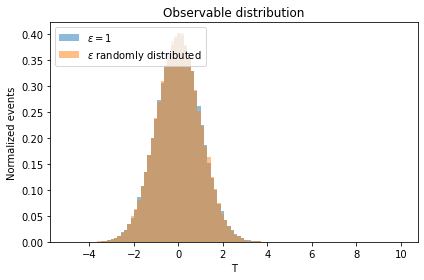

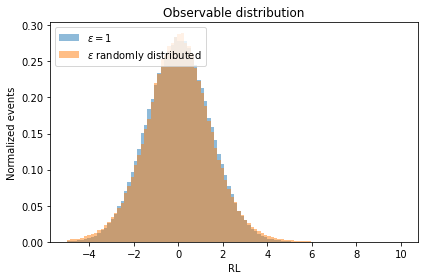

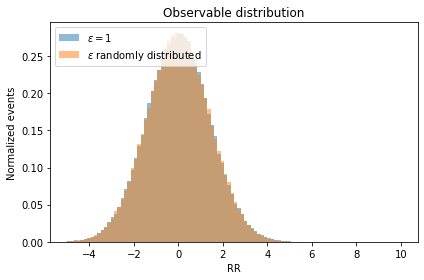

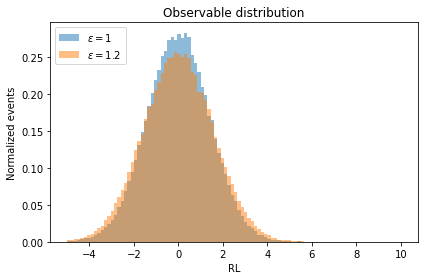

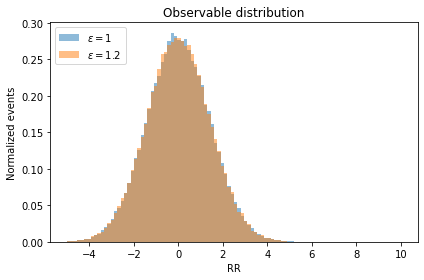

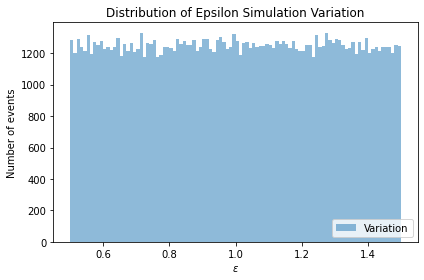

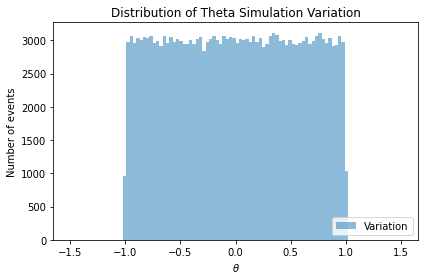

In [9]:
# Generate toy data for W1 training

Nsim = 200000
Ntest = 100000

# simulation
mu_sim = 0
sigma_sim = 1
alpha_sim = 0
delta_sim = 1
beta_sim = 0
epsilon_sim = 1
T_sim = np.random.normal(mu_sim,sigma_sim,Nsim).reshape(-1, 1)
RL_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)
RR_sim = np.random.normal(T_sim+alpha_sim,delta_sim)

# simulation with theta variation (theta value randomly sampled)
epsilon0_sim = np.random.uniform(0.2, 1.8, Nsim).reshape(-1, 1)
epsilon1_sim = np.random.uniform(0.2, 1.8, Nsim).reshape(-1, 1) # used for training
delta_epsilon = 0.8
# delta_epsilon = 0.2
theta0_sim = (epsilon0_sim-epsilon_sim)/delta_epsilon
theta1_sim = (epsilon1_sim-epsilon_sim)/delta_epsilon
RL1_sim = []
for i in range(Nsim):
    # use the same T_sim for R_sim variation
    RL1_sim.append(np.random.normal(T_sim[i]+beta_sim, epsilon1_sim[i,0]))
RL1_sim = np.array(RL1_sim)
RR1_sim = np.random.normal(T_sim+alpha_sim,delta_sim)

# test
epsilon_test = 1.2
theta_test = (epsilon_test-epsilon_sim)/delta_epsilon
T_test = np.random.normal(mu_sim,sigma_sim,Ntest).reshape(-1, 1)
RL_test0 = np.random.normal(T_test+beta_sim,epsilon_sim)
RR_test0 = np.random.normal(T_test+alpha_sim,delta_sim)
RL_test1 = np.random.normal(T_test+beta_sim,epsilon_test)
RR_test1 = np.random.normal(T_test+alpha_sim,delta_sim)

plt.hist(T_sim, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_sim}$", alpha=0.5)
plt.hist(T_test, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon$ randomly distributed", alpha=0.5)
plt.xlabel('T')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(RL_sim, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_sim}$", alpha=0.5)
plt.hist(RL1_sim, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon$ randomly distributed", alpha=0.5)
plt.xlabel('RL')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(RR_sim, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_sim}$", alpha=0.5)
plt.hist(RR1_sim, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon$ randomly distributed", alpha=0.5)
plt.xlabel('RR')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(RL_test0, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_sim}$", alpha=0.5)
plt.hist(RL_test1, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_test}$", alpha=0.5)
plt.xlabel('RL')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(RR_test0, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_sim}$", alpha=0.5)
plt.hist(RR_test1, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_test}$", alpha=0.5)
plt.xlabel('RR')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(epsilon1_sim, range=(0.5, 1.5), density=False, bins=100, label="Variation", alpha=0.5)
plt.xlabel(r'$\epsilon$')
plt.ylabel('Number of events')
plt.title(r'Distribution of Epsilon Simulation Variation')
plt.legend(loc='lower right')#, framealpha=0)
plt.tight_layout()
plt.show()

plt.hist(theta1_sim, range=(-1.5, 1.5), density=False, bins=100, label="Variation", alpha=0.5)
plt.xlabel(r'$\theta$')
plt.ylabel('Number of events')
plt.title(r'Distribution of Theta Simulation Variation')
plt.legend(loc='lower right')#, framealpha=0)
plt.tight_layout()
plt.show()

In [10]:
# Convert data into W1 dataset, data loaders and create loss function

R_sim = np.concatenate((RL_sim, RR_sim), axis=1)
R1_sim = np.concatenate((RL1_sim, RR1_sim), axis=1)

w1_ds = w1_dataset(T_sim, R_sim, theta0_sim, T_sim, R1_sim, theta1_sim)
std_params = [
    T_sim.mean(),
    T_sim.std(),
    torch.from_numpy(np.concatenate((R_sim, R1_sim)).mean(axis=0)).to(dvc),
    torch.from_numpy(np.concatenate((R_sim, R1_sim)).std(axis=0)).to(dvc)
]
print(std_params)
# split samples to 50% train and 50% test sets (can be adjusted)
w1_ds_train, w1_ds_test = random_split(w1_ds, [len(w1_ds)//2, len(w1_ds)-len(w1_ds)//2])#, generator=torch.Generator().manual_seed(42))
w1_dataloader_train = DataLoader(w1_ds_train, batch_size=100000, shuffle=True, num_workers=12)
w1_dataloader_test = DataLoader(w1_ds_test, batch_size=100000, shuffle=False, num_workers=12)

loss_fn_RT = nn.BCELoss()
loss_fn_T = nn.BCELoss()

[-0.0019171988419478243, 1.0029161612432431, tensor([-0.0005, -0.0042], device='cuda:0', dtype=torch.float64), tensor([1.4537, 1.4165], device='cuda:0', dtype=torch.float64)]


In [9]:
# Create W1 model and training it!

### PLEASE ENTER A NEW MODEL NAME FOR W1 ###
today = str(datetime.date.today())
w1_model_name = f'gaussian2D_deltaEpsilon0.8_{today}'
# w1_model_name = f'gaussian2D_deltaEpsilon0.2_{today}'
print(f"w1_mode_name: {w1_model_name}")

w1RT_model_network = w1RT_network(sigmoid=True, std_params=std_params, n_inputs=4).double().to(dvc)
optimizerRT = optim.Adam(w1RT_model_network.parameters(), lr=0.001)
w1RT_tr = w1_trainer(w1_dataloader_train, w1_dataloader_test, w1RT_model_network, loss_fn_RT, optimizerRT)

w1T_model_network = w1T_network(sigmoid=True, std_params=std_params, n_inputs=2).double().to(dvc)
optimizerT = optim.Adam(w1T_model_network.parameters(), lr=0.001)
w1T_tr = w1_trainer(w1_dataloader_train, w1_dataloader_test, w1T_model_network, loss_fn_T, optimizerT)

w1RT_tr.fit()
torch.save(w1RT_model_network, f'model/w1/W1RT_{w1_model_name}.pth')

w1T_tr.fit()
torch.save(w1T_model_network, f'model/w1/W1T_{w1_model_name}.pth')

w1_mode_name: gaussian2D_deltaEpsilon0.8_2022-12-16
===================== Model W1 =====================
w1RT_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=4, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
===================== Model W1 =====================
w1T_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=2, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
[Epoch   1] [Train_loss: 

[Epoch  78] [Train_loss: 0.637910 Train_auc: 0.663349] [Val_loss: 0.639677 Val_auc: 0.659271]
[Epoch  79] [Train_loss: 0.637952 Train_auc: 0.663299] [Val_loss: 0.639638 Val_auc: 0.659181]
[Epoch  80] [Train_loss: 0.637816 Train_auc: 0.663383] [Val_loss: 0.639624 Val_auc: 0.659235]
[Epoch  81] [Train_loss: 0.637699 Train_auc: 0.663428] [Val_loss: 0.639433 Val_auc: 0.659222]
[Epoch  82] [Train_loss: 0.637486 Train_auc: 0.663550] [Val_loss: 0.639285 Val_auc: 0.659345]
[Epoch  83] [Train_loss: 0.637420 Train_auc: 0.663567] [Val_loss: 0.639180 Val_auc: 0.659360]
[Epoch  84] [Train_loss: 0.637328 Train_auc: 0.663665] [Val_loss: 0.639138 Val_auc: 0.659421]
[Epoch  85] [Train_loss: 0.637326 Train_auc: 0.663630] [Val_loss: 0.639097 Val_auc: 0.659350]
[Epoch  86] [Train_loss: 0.637243 Train_auc: 0.663718] [Val_loss: 0.639082 Val_auc: 0.659452]
[Epoch  87] [Train_loss: 0.637117 Train_auc: 0.663770] [Val_loss: 0.638915 Val_auc: 0.659509]
[Epoch  88] [Train_loss: 0.637068 Train_auc: 0.663844] [Val_

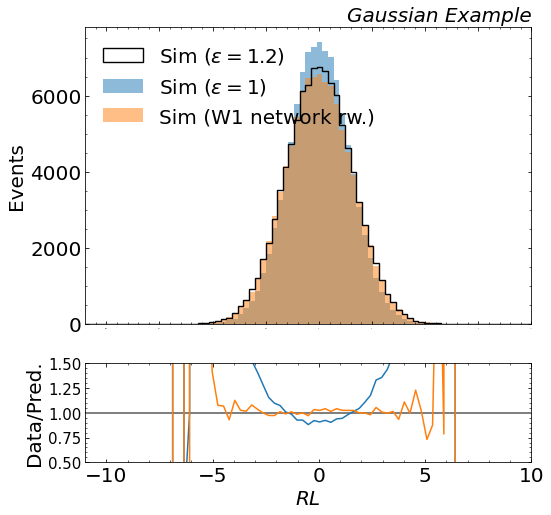

<Figure size 432x288 with 0 Axes>

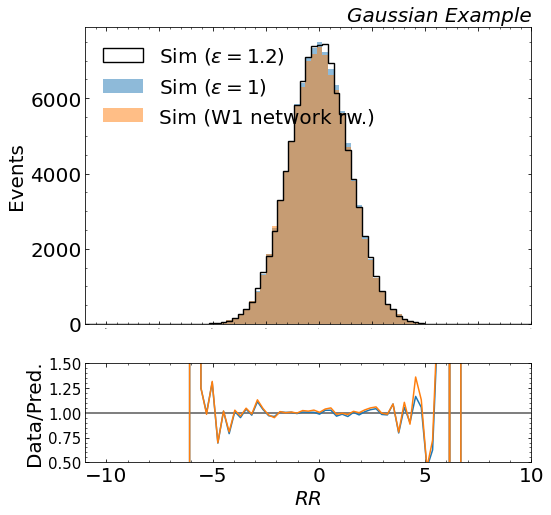

<Figure size 432x288 with 0 Axes>

In [10]:
# Test the trained W1 model

w1_model_name = 'gaussian2D_deltaEpsilon0.8_2022-12-16'
# w1_model_name = 'gaussian2D_deltaEpsilon0.2_2022-12-10'

w1RT_model_name = f'model/w1/W1RT_{w1_model_name}.pth'
w1T_model_name = f'model/w1/W1T_{w1_model_name}.pth'
w1RT_model_network = torch.load(w1RT_model_name).to(dvc)
w1T_model_network = torch.load(w1T_model_name).to(dvc)

today = str(datetime.date.today())

R_test0 = np.concatenate((RL_test0, RR_test0), axis=1)
w1_test_ds = w0_dataset(T_test, R_test0)
w1_test_dataloader = DataLoader(w1_test_ds, batch_size=64, shuffle=False, num_workers=12)

Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1RT_model_network, w1T_model_network, theta_test)
Ts_0, Rs_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RL$", density=False, save_name=f"gaussian2D_compare_RL_forW1network_deltaEpsilon0.8_{today}")
cpwr.add_data(RL_test1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=W1s_0, label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RR$", density=False, save_name=f"gaussian2D_compare_RR_forW1network_deltaEpsilon0.8_{today}")
cpwr.add_data(RR_test1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=W1s_0, label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

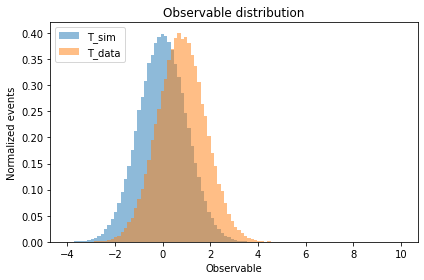

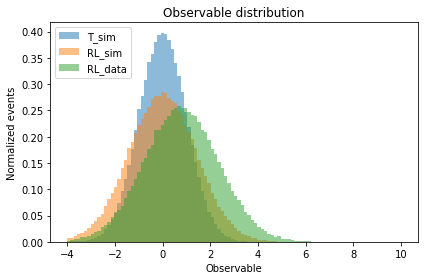

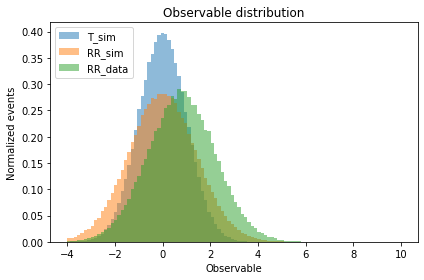

<Figure size 432x288 with 0 Axes>

In [7]:
# Generate data for W0 training (as well as theta)

Ndata = 100000
Nsim = 200000

mu_sim = 0
sigma_sim = 1
alpha_sim = 0
delta_sim = 1
beta_sim = 0
epsilon_sim = 1

mu_data = 0.8
sigma_data = 1
alpha_data = 0
delta_data = 1
beta_data = 0
epsilon_data = 1.2

# simulation
T_sim = np.random.normal(mu_sim,sigma_sim,Nsim).reshape(-1, 1)
RL_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)
RR_sim = np.random.normal(T_sim+alpha_sim,delta_sim)

# data
T_data = np.random.normal(mu_data,sigma_data,Ndata).reshape(-1, 1)
RL_data = np.random.normal(T_data+beta_data,epsilon_data)
RR_data = np.random.normal(T_data+alpha_data,delta_data)

plt.hist(T_sim, range=(-4, 10), density=True, bins=100, label="T_sim", alpha=0.5)
plt.hist(T_data, range=(-4, 10), density=True, bins=100, label="T_data", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(T_sim, range=(-4, 10), density=True, bins=100, label="T_sim", alpha=0.5)
plt.hist(RL_sim, range=(-4, 10), density=True, bins=100, label="RL_sim", alpha=0.5)
plt.hist(RL_data, range=(-4, 10), density=True, bins=100, label="RL_data", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(T_sim, range=(-4, 10), density=True, bins=100, label="T_sim", alpha=0.5)
plt.hist(RR_sim, range=(-4, 10), density=True, bins=100, label="RR_sim", alpha=0.5)
plt.hist(RR_data, range=(-4, 10), density=True, bins=100, label="RR_data", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

In [8]:
# Load W1 model and convert data into W0 datasets and data loaders
R_sim = np.concatenate((RL_sim, RR_sim), axis=1)
w0_ds = w0_dataset(T_sim, R_sim)
std_params = [
    T_sim.mean(),
    T_sim.std(),
    torch.from_numpy(R_sim.mean(axis=0)).to(dvc),
    torch.from_numpy(R_sim.std(axis=0)).to(dvc)
]
print(std_params)
# split samples to 50% train and 50% test sets (can be adjusted)
w0_ds_train, w0_ds_test = random_split(w0_ds, [len(w0_ds)//2, len(w0_ds)-len(w0_ds)//2])#, generator=torch.Generator().manual_seed(42))
w0_dataloader_train = DataLoader(w0_ds_train, batch_size=len(w0_ds_train), shuffle=True, num_workers=12)
w0_dataloader_test = DataLoader(w0_ds_test, batch_size=len(w0_ds_test), shuffle=False, num_workers=12)

# w1_model_name = 'gaussian2D_deltaEpsilon0.8_2022-12-16'
w1_model_name = 'gaussian2D_deltaEpsilon0.2_2022-12-10'
w1RT_model_name = f'model/w1/W1RT_{w1_model_name}.pth'
w1T_model_name = f'model/w1/W1T_{w1_model_name}.pth'
w1RT_model_network = torch.load(w1RT_model_name).to(dvc)
w1T_model_network = torch.load(w1T_model_name).to(dvc)

R_data = np.concatenate((RL_data, RR_data), axis=1)
loss_fn = NLLLoss_2D(R_data, np.linspace(-5,5,20), np.linspace(-5,5,20), device=dvc)

[-0.00025110169389801646, 1.0007578413388032, tensor([-0.0017,  0.0004], device='cuda:0', dtype=torch.float64), tensor([1.4131, 1.4144], device='cuda:0', dtype=torch.float64)]


In [10]:
# Create W0 model and train it (also theta)!

### PLEASE ENTER A NEW MODEL NAME FOR W0 AND THETA ###
today = str(datetime.date.today())
w0_model_name = f'w0_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_theta_w1_{w1_model_name}_{today}'
theta_model_name = f'theta_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_w0_w1_{w1_model_name}_{today}'
print(w0_model_name)
print(theta_model_name)

w0_model_network = w0_network(sigmoid=False, std_params=std_params).double().to(dvc)
theta_model = theta_module(0.).to(dvc)

ml = nn.ModuleList()
ml.append(w0_model_network)
ml.append(theta_model)

optimizer = optim.Adam(ml.parameters(), lr=0.001) #0.0005
# optimizer_1 = optim.Adam(theta_model.parameters(), lr=0.001)

w0_tr = w0_trainer(w0_dataloader_train, w0_dataloader_test, w0_model_network, w1RT_model_network, w1T_model_network, theta_model, loss_fn, optimizer)
w0_tr.fit()

torch.save(w0_model_network, f'model/w0/{w0_model_name}.pth')
torch.save(theta_model, f'model/theta/{theta_model_name}.pth')

w0_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_theta_w1_gaussian2D_deltaEpsilon0.8_2022-12-16_2022-12-17
theta_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_w0_w1_gaussian2D_deltaEpsilon0.8_2022-12-16_2022-12-17
===================== Model W0 =====================
w0_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=1, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
  )
)
===================== Model W1RT =====================
w1RT_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=4, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReL

[Epoch 152] [Train_loss: -568553.255638] [Val_loss: -568562.522973] [Theta: 0.12169662863016129]
[Epoch 153] [Train_loss: -568556.973805] [Val_loss: -568566.000529] [Theta: 0.12233103066682816]
[Epoch 154] [Train_loss: -568560.656252] [Val_loss: -568569.447376] [Theta: 0.12296309322118759]
[Epoch 155] [Train_loss: -568564.304697] [Val_loss: -568572.866209] [Theta: 0.12359286099672318]
[Epoch 156] [Train_loss: -568567.920030] [Val_loss: -568576.262477] [Theta: 0.12422039359807968]
[Epoch 157] [Train_loss: -568571.501033] [Val_loss: -568579.635161] [Theta: 0.12484565377235413]
[Epoch 158] [Train_loss: -568575.049273] [Val_loss: -568582.980554] [Theta: 0.1254686862230301]
[Epoch 159] [Train_loss: -568578.565161] [Val_loss: -568586.295787] [Theta: 0.12608951330184937]
[Epoch 160] [Train_loss: -568582.048237] [Val_loss: -568589.577751] [Theta: 0.12670813500881195]
[Epoch 161] [Train_loss: -568585.500544] [Val_loss: -568592.823094] [Theta: 0.12732458114624023]
[Epoch 162] [Train_loss: -56858

[Epoch 320] [Train_loss: -568855.523741] [Val_loss: -568846.300158] [Theta: 0.19891703128814697]
[Epoch 321] [Train_loss: -568856.146195] [Val_loss: -568846.883188] [Theta: 0.1992185413837433]
[Epoch 322] [Train_loss: -568856.761357] [Val_loss: -568847.459322] [Theta: 0.19951853156089783]
[Epoch 323] [Train_loss: -568857.369563] [Val_loss: -568848.027250] [Theta: 0.1998170167207718]
[Epoch 324] [Train_loss: -568857.970766] [Val_loss: -568848.586630] [Theta: 0.20011396706104279]
[Epoch 325] [Train_loss: -568858.564926] [Val_loss: -568849.138467] [Theta: 0.2004094123840332]
[Epoch 326] [Train_loss: -568859.152307] [Val_loss: -568849.683331] [Theta: 0.20070335268974304]
[Epoch 327] [Train_loss: -568859.732987] [Val_loss: -568850.220895] [Theta: 0.2009957730770111]
[Epoch 328] [Train_loss: -568860.307527] [Val_loss: -568850.751777] [Theta: 0.20128671824932098]
[Epoch 329] [Train_loss: -568860.874659] [Val_loss: -568851.275791] [Theta: 0.20157615840435028]
[Epoch 330] [Train_loss: -568861.4

[Epoch 488] [Train_loss: -568900.540399] [Val_loss: -568886.849952] [Theta: 0.23128589987754822]
[Epoch 489] [Train_loss: -568900.622590] [Val_loss: -568886.922751] [Theta: 0.23138970136642456]
[Epoch 490] [Train_loss: -568900.703756] [Val_loss: -568886.993681] [Theta: 0.23149274289608002]
[Epoch 491] [Train_loss: -568900.784481] [Val_loss: -568887.058925] [Theta: 0.23159505426883698]
[Epoch 492] [Train_loss: -568900.864381] [Val_loss: -568887.127302] [Theta: 0.23169666528701782]
[Epoch 493] [Train_loss: -568900.942613] [Val_loss: -568887.191209] [Theta: 0.23179756104946136]
[Epoch 494] [Train_loss: -568901.019397] [Val_loss: -568887.256045] [Theta: 0.2318977564573288]
[Epoch 495] [Train_loss: -568901.095181] [Val_loss: -568887.320948] [Theta: 0.2319972664117813]
[Epoch 496] [Train_loss: -568901.170124] [Val_loss: -568887.387005] [Theta: 0.2320961058139801]
[Epoch 497] [Train_loss: -568901.244131] [Val_loss: -568887.453024] [Theta: 0.2321942299604416]
[Epoch 498] [Train_loss: -568901.3

[Epoch 656] [Train_loss: -568907.442293] [Val_loss: -568891.751692] [Theta: 0.24085849523544312]
[Epoch 657] [Train_loss: -568907.465739] [Val_loss: -568891.763333] [Theta: 0.24088379740715027]
[Epoch 658] [Train_loss: -568907.488956] [Val_loss: -568891.776141] [Theta: 0.24090886116027832]
[Epoch 659] [Train_loss: -568907.511830] [Val_loss: -568891.790365] [Theta: 0.24093368649482727]
[Epoch 660] [Train_loss: -568907.534859] [Val_loss: -568891.803277] [Theta: 0.24095827341079712]
[Epoch 661] [Train_loss: -568907.556695] [Val_loss: -568891.815603] [Theta: 0.24098265171051025]
[Epoch 662] [Train_loss: -568907.579574] [Val_loss: -568891.830545] [Theta: 0.24100683629512787]
[Epoch 663] [Train_loss: -568907.601892] [Val_loss: -568891.847276] [Theta: 0.24103082716464996]
[Epoch 664] [Train_loss: -568907.623996] [Val_loss: -568891.866270] [Theta: 0.24105463922023773]
[Epoch 665] [Train_loss: -568907.646208] [Val_loss: -568891.884040] [Theta: 0.2410782426595688]
[Epoch 666] [Train_loss: -56890

[Epoch 824] [Train_loss: -568910.274244] [Val_loss: -568893.272157] [Theta: 0.24293069541454315]
[Epoch 825] [Train_loss: -568910.287586] [Val_loss: -568893.277301] [Theta: 0.24293546378612518]
[Epoch 826] [Train_loss: -568910.300640] [Val_loss: -568893.281737] [Theta: 0.24294018745422363]
[Epoch 827] [Train_loss: -568910.313900] [Val_loss: -568893.286142] [Theta: 0.2429448515176773]
[Epoch 828] [Train_loss: -568910.326891] [Val_loss: -568893.293795] [Theta: 0.2429494708776474]
[Epoch 829] [Train_loss: -568910.339924] [Val_loss: -568893.303807] [Theta: 0.2429540455341339]
[Epoch 830] [Train_loss: -568910.352872] [Val_loss: -568893.313301] [Theta: 0.24295856058597565]
[Epoch 831] [Train_loss: -568910.365932] [Val_loss: -568893.319894] [Theta: 0.2429630309343338]
[Epoch 832] [Train_loss: -568910.379005] [Val_loss: -568893.328967] [Theta: 0.24296744167804718]
[Epoch 833] [Train_loss: -568910.392267] [Val_loss: -568893.341696] [Theta: 0.24297180771827698]
[Epoch 834] [Train_loss: -568910.4

[Epoch 992] [Train_loss: -568912.559620] [Val_loss: -568895.021013] [Theta: 0.24333900213241577]
[Epoch 993] [Train_loss: -568912.573891] [Val_loss: -568895.027961] [Theta: 0.243340402841568]
[Epoch 994] [Train_loss: -568912.587943] [Val_loss: -568895.031792] [Theta: 0.24334178864955902]
[Epoch 995] [Train_loss: -568912.602156] [Val_loss: -568895.044978] [Theta: 0.24334317445755005]
[Epoch 996] [Train_loss: -568912.616778] [Val_loss: -568895.061885] [Theta: 0.24334456026554108]
[Epoch 997] [Train_loss: -568912.630705] [Val_loss: -568895.076967] [Theta: 0.2433459311723709]
[Epoch 998] [Train_loss: -568912.644954] [Val_loss: -568895.091844] [Theta: 0.24334728717803955]
[Epoch 999] [Train_loss: -568912.659004] [Val_loss: -568895.100877] [Theta: 0.243348628282547]


In [13]:
w0_tr.fit(10000)

torch.save(w0_model_network, f'model/w0/{w0_model_name}.pth')
torch.save(theta_model, f'model/theta/{theta_model_name}.pth')

[Epoch 1000] [Train_loss: -568912.673598] [Val_loss: -568895.110925] [Theta: 0.24334995448589325]
[Epoch 1001] [Train_loss: -568912.687909] [Val_loss: -568895.127190] [Theta: 0.2433512806892395]
[Epoch 1002] [Train_loss: -568912.701919] [Val_loss: -568895.141318] [Theta: 0.24335259199142456]
[Epoch 1003] [Train_loss: -568912.716181] [Val_loss: -568895.149136] [Theta: 0.24335388839244843]
[Epoch 1004] [Train_loss: -568912.730122] [Val_loss: -568895.148418] [Theta: 0.2433551847934723]
[Epoch 1005] [Train_loss: -568912.744159] [Val_loss: -568895.159464] [Theta: 0.24335648119449615]
[Epoch 1006] [Train_loss: -568912.758100] [Val_loss: -568895.174618] [Theta: 0.24335777759552002]
[Epoch 1007] [Train_loss: -568912.771854] [Val_loss: -568895.186210] [Theta: 0.2433590590953827]
[Epoch 1008] [Train_loss: -568912.785565] [Val_loss: -568895.189078] [Theta: 0.24336034059524536]
[Epoch 1009] [Train_loss: -568912.798920] [Val_loss: -568895.201763] [Theta: 0.24336162209510803]
[Epoch 1010] [Train_los

Fitted epsilon = 1.194805872440338
[Test_loss: -569447.657486]


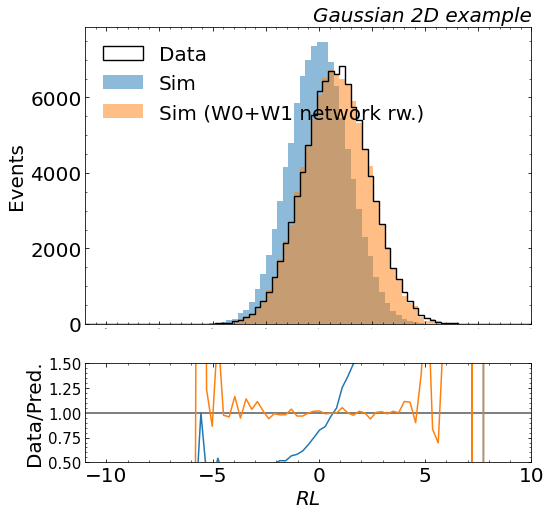

<Figure size 432x288 with 0 Axes>

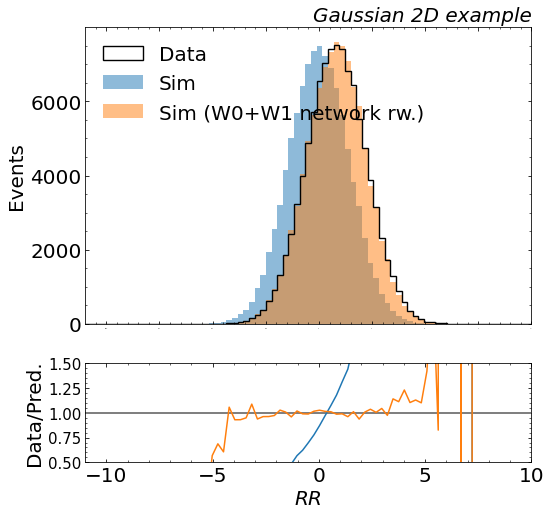

<Figure size 432x288 with 0 Axes>

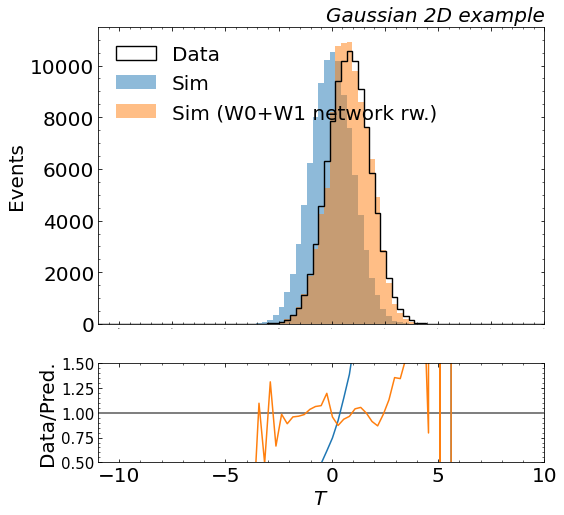

<Figure size 432x288 with 0 Axes>

In [20]:
# w0_model_network_0 = w0_model_network

w0_model_name_0 = f'w0_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_theta_w1_gaussian2D_deltaEpsilon0.8_2022-12-16_2022-12-17'
w0_model_network_0 = torch.load(f'model/w0/{w0_model_name_0}.pth')

theta_model_name_0 = f'theta_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_w0_w1_gaussian2D_deltaEpsilon0.8_2022-12-16_2022-12-17'
theta_model_0 = torch.load(f'model/theta/{theta_model_name_0}.pth')

# w0_model_network_0 = w0_model_network
# theta_model_0 = theta_model

print(f"Fitted epsilon = {theta_model_0().item()*0.8+1}")

today = str(datetime.date.today())

Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = test_w0(w0_dataloader_test, w0_model_network_0, w1RT_model_network, w1T_model_network, theta_model_0, loss_fn)
Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy(), W0s_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RL$", density=False, save_name=f"Gaussian2D_Compare_RL_{today}", header="Gaussian 2D example")
cpwr.add_data(R_data[:,0], label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=Ws_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RR$", density=False, save_name=f"Gaussian2D_Compare_RR_{today}", header="Gaussian 2D example")
cpwr.add_data(R_data[:,1], label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=Ws_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$T$", density=False, save_name=f"Gaussian2D_Compare_T_{today}", header="Gaussian 2D example")
cpwr.add_data(T_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Ts_0, label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Ts_0, weights=W0s_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

Fitted epsilon = 1.146053946018219
[Test_loss: -568732.628171]


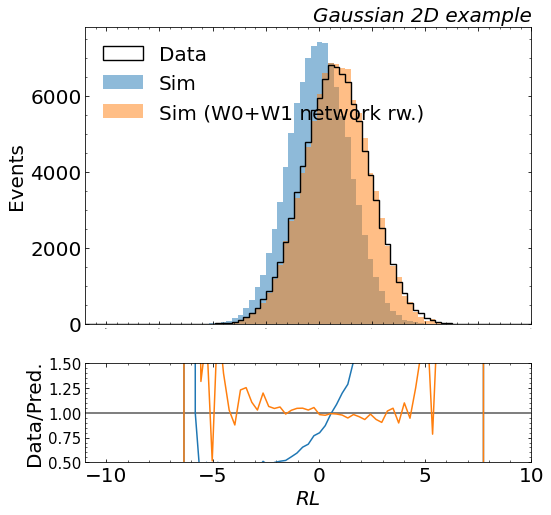

<Figure size 432x288 with 0 Axes>

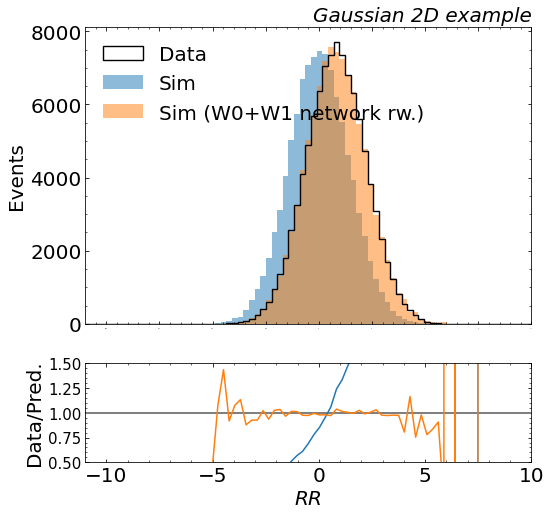

<Figure size 432x288 with 0 Axes>

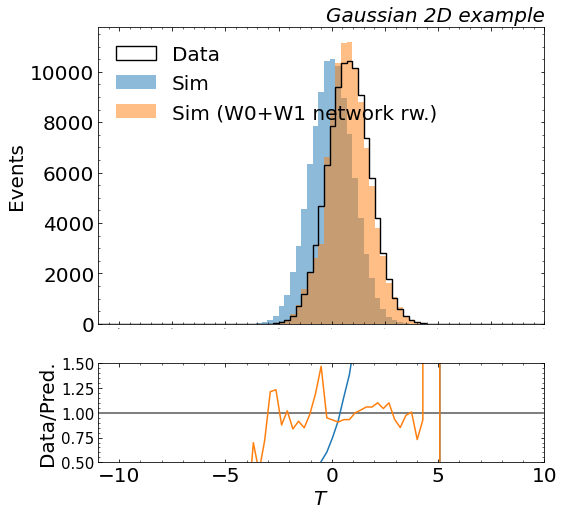

<Figure size 432x288 with 0 Axes>

In [9]:
# w0_model_network_0 = w0_model_network

w0_model_name_0 = f'w0_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_theta_w1_gaussian2D_deltaEpsilon0.2_2022-12-10_2022-12-10'
w0_model_network_0 = torch.load(f'model/w0/{w0_model_name_0}.pth')

theta_model_name_0 = f'theta_gaussian2D_mu0.8epsilon1.2_Lr0p001_with_w0_w1_gaussian2D_deltaEpsilon0.2_2022-12-10_2022-12-10'
theta_model_0 = torch.load(f'model/theta/{theta_model_name_0}.pth')

# w0_model_network_0 = w0_model_network
# theta_model_0 = theta_model

print(f"Fitted epsilon = {theta_model_0().item()*0.2+1}")

today = str(datetime.date.today())

Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = test_w0(w0_dataloader_test, w0_model_network_0, w1RT_model_network, w1T_model_network, theta_model_0, loss_fn)
Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy(), W0s_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RL$", density=False, save_name=f"Gaussian2D_Compare_RL_{today}", header="Gaussian 2D example")
cpwr.add_data(R_data[:,0], label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=Ws_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$RR$", density=False, save_name=f"Gaussian2D_Compare_RR_{today}", header="Gaussian 2D example")
cpwr.add_data(R_data[:,1], label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=Ws_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$T$", density=False, save_name=f"Gaussian2D_Compare_T_{today}", header="Gaussian 2D example")
cpwr.add_data(T_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Ts_0, label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Ts_0, weights=W0s_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

In [11]:
w0_model_network = w0_model_network_0
theta_model = theta_model_0

ml = nn.ModuleList()
ml.append(w0_model_network)
ml.append(theta_model)

optimizer = optim.Adam(ml.parameters(), lr=0.0005)
# optimizer_1 = optim.Adam(theta_model.parameters(), lr=0.001)

w0_tr = w0_trainer(w0_dataloader_train, w0_dataloader_test, w0_model_network, w1RT_model_network, w1T_model_network, theta_model, loss_fn, optimizer)
w0_tr.fit()

===================== Model W0 =====================
w0_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=1, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
  )
)
===================== Model W1RT =====================
w1RT_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=4, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
===================== Model W1T =====================
w1T_network(
  (linear_relu_stack): Sequential(

[Epoch  72] [Train_loss: -568994.897573] [Val_loss: -568976.373468] [Theta: 0.7648666501045227]
[Epoch  73] [Train_loss: -568995.150009] [Val_loss: -568975.977711] [Theta: 0.7653172612190247]
[Epoch  74] [Train_loss: -568995.379275] [Val_loss: -568975.810806] [Theta: 0.7657671570777893]
[Epoch  75] [Train_loss: -568995.647217] [Val_loss: -568976.097348] [Theta: 0.7662164568901062]
[Epoch  76] [Train_loss: -568995.917533] [Val_loss: -568976.664547] [Theta: 0.7666651010513306]
[Epoch  77] [Train_loss: -568996.151003] [Val_loss: -568977.153475] [Theta: 0.7671129107475281]
[Epoch  78] [Train_loss: -568996.390155] [Val_loss: -568977.345726] [Theta: 0.767559826374054]
[Epoch  79] [Train_loss: -568996.655739] [Val_loss: -568977.227551] [Theta: 0.7680058479309082]
[Epoch  80] [Train_loss: -568996.901957] [Val_loss: -568976.958768] [Theta: 0.7684510946273804]
[Epoch  81] [Train_loss: -568997.130287] [Val_loss: -568976.812325] [Theta: 0.7688956260681152]
[Epoch  82] [Train_loss: -568997.376783] 

[Epoch 242] [Train_loss: -569019.311667] [Val_loss: -568982.343856] [Theta: 0.8277433514595032]
[Epoch 243] [Train_loss: -569019.384954] [Val_loss: -568982.345185] [Theta: 0.8280317783355713]
Early stopping! Restore state at epoch 232.
[Best_val_loss: -568982.411059]
Fitted theta: 0.8280317783355713


In [22]:
# Just to check the fitted epsilon value from the optimization

print("mu data = 0.2, Delta epsilon = 0.8, fitted epsilon = 1.1776933312416076")
print("mu data = 0.8, Delta epsilon = 0.8, fitted epsilon = 1.200434398651123")
print(f"mu data = 0.8, Delta epsilon = 0.2, fitted epsilon = {theta_model().item()*0.2+1}")
# print(theta_model().item()*0.8+1)

mu data = 0.2, Delta epsilon = 0.8, fitted epsilon = 1.1776933312416076
mu data = 0.8, Delta epsilon = 0.8, fitted epsilon = 1.200434398651123
mu data = 0.8, Delta epsilon = 0.2, fitted epsilon = 1.1414368510246278
